# User Wise Hybrid

In [1]:
from Utils.Toolkit import get_data

data = get_data()

URM = data['train'].tocsr()
ICM = data['ICM_subclass'].tocsr()

## Let's divide users intro groups

In [2]:
import numpy as np

group0 = []
group1 = []
group2 = []
group3 = []
group4 = []
group5 = []
group6 = []
group7 = []
group8 = []
group9 = []

for user_id in range(URM.shape[0]):
    start_pos = URM.indptr[user_id]
    end_pos = URM.indptr[user_id + 1]
    if len(URM.data[start_pos:end_pos]) == 0:
        group0.append(user_id)
    elif 0 < len(URM.data[start_pos:end_pos]) <= 2:
        group1.append(user_id)
    elif 2 < len(URM.data[start_pos:end_pos]) <= 5:
        group2.append(user_id)
    elif 5 < len(URM.data[start_pos:end_pos]) <= 10:
        group3.append(user_id)
    elif 10 < len(URM.data[start_pos:end_pos]) <= 20:
        group4.append(user_id)
    elif 20 < len(URM.data[start_pos:end_pos]) <= 30:
        group5.append(user_id)
    elif 40 < len(URM.data[start_pos:end_pos]) <= 60:
        group6.append(user_id)
    elif 60 < len(URM.data[start_pos:end_pos]) <= 100:
        group7.append(user_id)
    elif 100 < len(URM.data[start_pos:end_pos]) <= 300:
        group8.append(user_id)
    elif 300 < len(URM.data[start_pos:end_pos]) <= 10000:
        group9.append(user_id)

        
group0 = np.array(group0)
group1 = np.array(group1)
group2 = np.array(group2)
group3 = np.array(group3)
group4 = np.array(group4)
group5 = np.array(group5)
group6 = np.array(group6)
group7 = np.array(group7)
group8 = np.array(group8)
group9 = np.array(group9)

group = np.array([group0, group1, group2, group3, group4, group5, group6, group7, group8, group9])

In [3]:
print(str(len(group0)) + " Cold users")
print(len(group1))
print(len(group2))
print(len(group3))
print(len(group4))
print(len(group5))
print(len(group6))
print(len(group7))
print(len(group8))
print(len(group9))

6473 Cold users
3695
4556
5034
5443
2502
1183
530
131
5


In [4]:
from Recommenders.CF.FeatureBoostedItemCollaborative import FeatureBoostedItemCollaborativeFiltering
from Recommenders.CF.item_cf import ItemBasedCollaborativeFiltering
from Recommenders.CF.user_cf import UserBasedCollaborativeFiltering
from Recommenders.CBF.user_CBF import UserContentBasedRecommender
from Recommenders.CBF.item_CBF import ItemContentBasedRecommender
from Recommenders.SLIM.SLIM_BPR_Cython import SLIM_BPR_Cython

itemCF = ItemBasedCollaborativeFiltering(29, 5)
itemCF.fit(URM.copy(), ICM)

userCBF = UserContentBasedRecommender(1000, 7900)
userCBF.fit(URM.copy(), data['UCM'])

userCF = UserBasedCollaborativeFiltering(94, 19)
userCF.fit(URM.copy())

itemCBF = ItemContentBasedRecommender(100, 5)
itemCBF.fit(URM.copy(), ICM)

slim = SLIM_BPR_Cython(epochs=5000,
                               topK=20,
                               lambda_i=1.0,
                               lambda_j=7.0,
                               positive_threshold=1,
                               sgd_mode="adam",
                               symmetric=False,
                               learning_rate=1e-4)

In [5]:
MAPs_ICF = []
MAPs_UCBF = []
MAPs_ICBF = []
MAPs_UCF = []
MAPs_slim = []

slim.fit(URM.copy())

for group_id in range(len(group)):
    
    result = itemCF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_ICF.append(result['MAP'])
    
    result = userCBF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_UCBF.append(result['MAP'])
    
    result = itemCBF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_ICBF.append(result['MAP'])
    
    result = userCF.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_UCF.append(result['MAP'])
    
    result = slim.evaluate_MAP_target(data['test'], group[group_id])
    MAPs_slim.append(result['MAP'])

Evaluating MAP with target:   3%|▎         | 202/6473 [00:00<00:03, 2013.67it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:  10%|▉         | 630/6473 [00:00<00:01, 3042.81it/s]

UserContentBasedRecommender -> MAP: 0.0015	TOTAL MISS=2699	Relevant=118


Evaluating MAP with target:   9%|▉         | 602/6473 [00:00<00:02, 2884.96it/s]

ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   4%|▍         | 286/6473 [00:00<00:02, 2858.44it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   3%|▎         | 127/3695 [00:00<00:02, 1262.75it/s]

BaseRecommender -> MAP: 0.0000	TOTAL MISS=2813	Relevant=4


Evaluating MAP with target:   5%|▍         | 169/3695 [00:00<00:04, 831.39it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0068	TOTAL MISS=3378	Relevant=317


Evaluating MAP with target:   4%|▎         | 135/3695 [00:00<00:02, 1345.53it/s]

UserContentBasedRecommender -> MAP: 0.0011	TOTAL MISS=3581	Relevant=114


Evaluating MAP with target:   3%|▎         | 109/3695 [00:00<00:03, 1082.38it/s]

ItemContentBasedRecommender -> MAP: 0.0007	TOTAL MISS=3643	Relevant=52


Evaluating MAP with target:   7%|▋         | 277/3695 [00:00<00:02, 1369.67it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0065	TOTAL MISS=3343	Relevant=352


Evaluating MAP with target:   3%|▎         | 122/4556 [00:00<00:03, 1217.57it/s]

BaseRecommender -> MAP: 0.0062	TOTAL MISS=3366	Relevant=329


Evaluating MAP with target:   2%|▏         | 84/4556 [00:00<00:05, 837.05it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0092	TOTAL MISS=4056	Relevant=500


Evaluating MAP with target:   2%|▏         | 97/4556 [00:00<00:04, 965.13it/s]

UserContentBasedRecommender -> MAP: 0.0016	TOTAL MISS=4403	Relevant=153


Evaluating MAP with target:   2%|▏         | 108/4556 [00:00<00:04, 1076.47it/s]

ItemContentBasedRecommender -> MAP: 0.0010	TOTAL MISS=4486	Relevant=70


Evaluating MAP with target:   6%|▌         | 263/4556 [00:00<00:03, 1310.29it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0061	TOTAL MISS=4208	Relevant=348


Evaluating MAP with target:   2%|▏         | 111/5034 [00:00<00:04, 1104.05it/s]

BaseRecommender -> MAP: 0.0079	TOTAL MISS=4100	Relevant=456


Evaluating MAP with target:   2%|▏         | 80/5034 [00:00<00:06, 791.35it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0094	TOTAL MISS=4476	Relevant=558


Evaluating MAP with target:   2%|▏         | 113/5034 [00:00<00:04, 1123.87it/s]

UserContentBasedRecommender -> MAP: 0.0012	TOTAL MISS=4911	Relevant=123


Evaluating MAP with target:   2%|▏         | 106/5034 [00:00<00:04, 1052.24it/s]

ItemContentBasedRecommender -> MAP: 0.0010	TOTAL MISS=4964	Relevant=70


Evaluating MAP with target:   2%|▏         | 109/5034 [00:00<00:04, 1085.79it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0046	TOTAL MISS=4755	Relevant=279


Evaluating MAP with target:   2%|▏         | 94/5443 [00:00<00:05, 937.65it/s]

BaseRecommender -> MAP: 0.0085	TOTAL MISS=4550	Relevant=484


Evaluating MAP with target:   3%|▎         | 147/5443 [00:00<00:07, 725.88it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0097	TOTAL MISS=4835	Relevant=608


Evaluating MAP with target:   2%|▏         | 103/5443 [00:00<00:05, 1024.39it/s]

UserContentBasedRecommender -> MAP: 0.0014	TOTAL MISS=5305	Relevant=138


Evaluating MAP with target:   1%|▏         | 78/5443 [00:00<00:06, 778.22it/s]

ItemContentBasedRecommender -> MAP: 0.0009	TOTAL MISS=5371	Relevant=72


Evaluating MAP with target:   4%|▎         | 203/5443 [00:00<00:05, 1013.50it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0027	TOTAL MISS=5279	Relevant=164


Evaluating MAP with target:   8%|▊         | 192/2502 [00:00<00:02, 948.74it/s]

BaseRecommender -> MAP: 0.0081	TOTAL MISS=4946	Relevant=497


Evaluating MAP with target:   3%|▎         | 68/2502 [00:00<00:03, 678.35it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0037	TOTAL MISS=2252	Relevant=250


Evaluating MAP with target:   4%|▍         | 98/2502 [00:00<00:02, 976.83it/s]

UserContentBasedRecommender -> MAP: 0.0005	TOTAL MISS=2449	Relevant=53


Evaluating MAP with target:   8%|▊         | 195/2502 [00:00<00:02, 960.87it/s]

ItemContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=2488	Relevant=14


Evaluating MAP with target:   7%|▋         | 185/2502 [00:00<00:02, 897.27it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0006	TOTAL MISS=2459	Relevant=43


Evaluating MAP with target:  12%|█▏        | 146/1183 [00:00<00:01, 729.23it/s]

BaseRecommender -> MAP: 0.0028	TOTAL MISS=2304	Relevant=198


Evaluating MAP with target:   8%|▊         | 91/1183 [00:00<00:02, 446.77it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0012	TOTAL MISS=1093	Relevant=90


Evaluating MAP with target:   6%|▋         | 74/1183 [00:00<00:01, 731.15it/s]

UserContentBasedRecommender -> MAP: 0.0002	TOTAL MISS=1157	Relevant=26


Evaluating MAP with target:   6%|▋         | 75/1183 [00:00<00:01, 745.82it/s]

ItemContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=1172	Relevant=11


Evaluating MAP with target:  13%|█▎        | 151/1183 [00:00<00:01, 743.65it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0002	TOTAL MISS=1171	Relevant=12


Evaluating MAP with target:  13%|█▎        | 70/530 [00:00<00:00, 696.21it/s]

BaseRecommender -> MAP: 0.0009	TOTAL MISS=1115	Relevant=68


Evaluating MAP with target:   9%|▉         | 47/530 [00:00<00:01, 469.17it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0004	TOTAL MISS=488	Relevant=42


Evaluating MAP with target:  14%|█▍        | 76/530 [00:00<00:00, 752.68it/s]

UserContentBasedRecommender -> MAP: 0.0001	TOTAL MISS=522	Relevant=8


Evaluating MAP with target:  14%|█▍        | 74/530 [00:00<00:00, 733.11it/s]

ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=523	Relevant=7


Evaluating MAP with target:  14%|█▍        | 74/530 [00:00<00:00, 732.17it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=528	Relevant=2


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

BaseRecommender -> MAP: 0.0002	TOTAL MISS=503	Relevant=27
ItemBasedCollaborativeFiltering -> MAP: 0.0001	TOTAL MISS=125	Relevant=6


Evaluating MAP with target:   0%|          | 0/131 [00:00<?, ?it/s]

UserContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=126	Relevant=5
ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=131	Relevant=0


Evaluating MAP with target:   0%|          | 0/5 [00:00<?, ?it/s]

UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=131	Relevant=0
BaseRecommender -> MAP: 0.0001	TOTAL MISS=123	Relevant=8


Evaluating MAP with target: 100%|██████████| 5/5 [00:00<00:00, 541.35it/s]

ItemBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
UserContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
ItemContentBasedRecommender -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
UserBasedCollaborativeFiltering -> MAP: 0.0000	TOTAL MISS=5	Relevant=0
BaseRecommender -> MAP: 0.0000	TOTAL MISS=5	Relevant=0


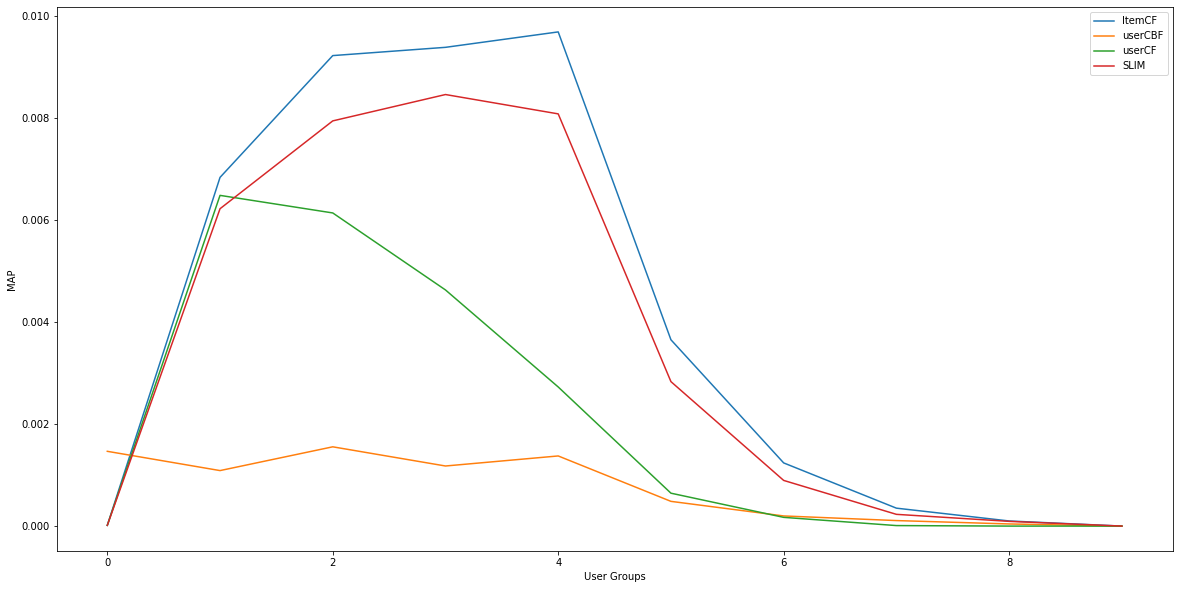

In [6]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.figure(figsize=(20,10))
pyplot.plot(MAPs_ICF, label="ItemCF")
pyplot.plot(MAPs_UCBF, label="userCBF")
pyplot.plot(MAPs_UCF, label="userCF")
pyplot.plot(MAPs_slim, label="SLIM")
pyplot.ylabel('MAP')
pyplot.xlabel('User Groups')
pyplot.legend()
pyplot.show()

# UserCBF tuning for cold users

Evaluating MAP with target: 100%|██████████| 6473/6473 [00:06<00:00, 1039.33it/s]


UserContentBasedRecommender -> MAP: 0.0015	TOTAL MISS=2696	Relevant=121


Evaluating MAP with target: 100%|██████████| 6473/6473 [00:07<00:00, 873.10it/s] 


UserContentBasedRecommender -> MAP: 0.0015	TOTAL MISS=2696	Relevant=121


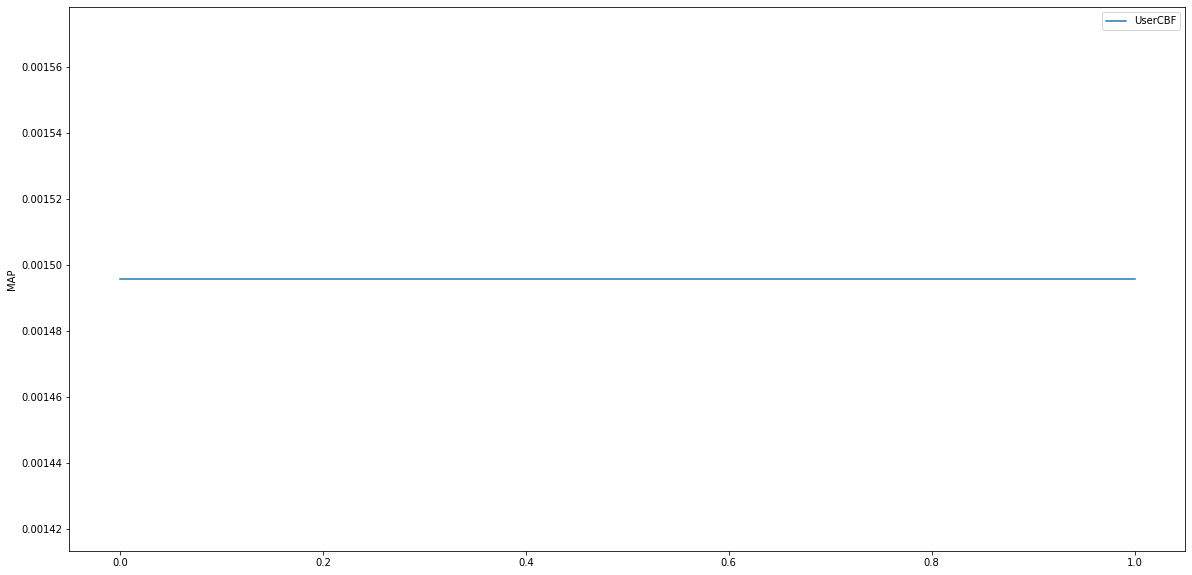

In [18]:
from Utils.Toolkit import get_URM_TFIDF

MAP_topK = []
MAP_shrink = []
for shrink in [7950, 7960]:
    userCBF = UserContentBasedRecommender(10300, shrink)
    UCM = data['UCM']
    UCM = get_URM_TFIDF(UCM)
    userCBF.fit(URM.copy(), UCM)
    result = userCBF.evaluate_MAP_target(data['test'], group[0])
    MAP_topK.append(result['MAP'])

pyplot.figure(figsize=(20,10))
pyplot.plot(MAP_topK, label="UserCBF")
pyplot.ylabel('MAP')
pyplot.legend()
pyplot.show()

# ItemCBF tuning

In [ ]:
MAP_topK = []
for topK in [5, 10, 30, 50, 100, 200, 400, 700, 1000]:
    itemCBF = ItemContentBasedRecommender(topK, 5)
    itemCBF.fit(URM.copy(), ICM)
    result = userCBF.evaluate_MAP_target(data['test'], group[0])
    MAP_topK.append(result['MAP'])

pyplot.figure(figsize=(20,10))
pyplot.plot(MAP_topK, label="UserCBF")
pyplot.ylabel('MAP')
pyplot.legend()
pyplot.show()